In [150]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [151]:
import os
import numpy as np
import pandas as pd
import json
import pickle as cp
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
import torch

In [152]:
def getScore(model,X):
    input = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
      tape.watch(input)
      output = model(input)
    gradients = np.absolute(tape.gradient(output, input))

    g = gradients.sum(axis=1)[:,1:]

    init = 0
    monthly_gradients = []
    for days in mnth_days:
        mgrad = gradients[init:init+days]
        monthly_gradients.append(mgrad.sum(axis=1).sum(axis=0)/days)
        init=init+days
    monthly_gradients = np.array(monthly_gradients)

    return gradients ### Returning the raw gradients instead of monthly aggregated values (temporary)

In [153]:
def addSpanLag(data, events=[], look_back=7, look_ahead = 7, season=0,span=0):
    ### Adding span (required for weekly, monthly average data)
    if span>1:
        nts = []
        ind = 0
        while ind < len(ts):
            tmpts = ts[ind:ind+span]
            print (tmpts)
            dt = tmpts[0]
            vals = [k for k in tmpts]
            pr = sum(vals)/len(vals)
            nts.append((dt,pr))
            ind+=span
        ts = nts


    ### Adding lag (based on look back and look ahead)

    if len(events) > 0:
        input = np.append(data,events,axis=1)
    else:
        input = data
    if season>0:
        season = np.array([k%season for k in range(data.shape[0])])
        season = season.reshape(len(season),1)
        input = np.append(input,season,axis=1)


    ind = 0
    X_data = []
    y_data = []

    while ind + look_back + look_ahead < len(data):

        X = input[ind:ind+look_back]
        Y = data[ind+look_back+look_ahead]
        X_data.append(X)
        y_data.append(Y)
        ind+=1
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

In [5]:
#### TO run this block return monthly aggregated gradients from the getScore function

crops = ['Onion','Potato','Rice','Wheat']
path='/home/sunchak/projects/news_analytics/REN/'
event_dict = {}
for crop in crops:

  model = keras.models.load_model(path+'onedayahead_logreturn/ren_'+crop)
  mnth_days = [31,28,31,30,31,30,31,31,30,31,30,31]*3
  fileformat = path+'food_price_data/%s.csv'
  data = pd.read_csv(fileformat%(crop))
  price = data['price']
  dates = data['date']
  #foodpriceDf = pd.Series(food_price,index=dates)
  start_date = '2012-12-24'
  end_date = '2015-12-31'
  price.index = dates
  range_price = price[start_date:end_date]

  food_price = np.log(range_price).diff().dropna()
  price_diff = np.array(food_price).reshape(food_price.shape[0],1)


  train = np.load(path+'embeddings/events_train.npy')
  test = np.load(path+'embeddings/events_test.npy')
  events = np.append(train,test, axis=0)[2548:2548+1102]

  X, y   = addSpanLag(price_diff,events,look_back=7,look_ahead=0,season=0)
  gradients = getScore(model,X)
  #gradients.shape
  evnt_grads = gradients[:,1:]
  top1 = []
  top10 = []
  for k in range(36):
    a = evnt_grads[k]
    ind = np.argpartition(a, -10)[-10:]
    top10.append(np.flip(ind))
    top1.append(np.argmax(a))
  event_dict[crop] = {}
  for evnt in top1:
    event_dict[crop][evnt] = evnt_grads[:,evnt]
cp.dump(event_dict,open(os.path.join(path,'event importance','event_scores.dict'),'wb'))

In [162]:
#### TO run this block return raw gradients from the getScore function. This block is computing the product of event values and gradients for each day jan 2013

crops = ['Onion','Potato','Wheat','Rice']
path='/content/gdrive/MyDrive/Colab Notebooks/REN/'
crop = 'Onion'
mnth_days = [31,28,31,30,31,30,31,31,30,31,30,31]*3
fileformat = path+'food_price_data/%s.csv'
for crop in crops:
  print(crop)
  model_path = 'onedayahead_logreturn/ren_'+crop
  event_dict = {}

  #if True:

  model = keras.models.load_model(path+model_path)

  data = pd.read_csv(fileformat%(crop))
  price = data['price']
  dates = data['date']
  price_array = price.to_numpy()[2557:]
  #foodpriceDf = pd.Series(food_price,index=dates)
  start_date = '2012-12-25'
  end_date = '2015-12-31'
  price.index = dates
  price = np.log(price).diff()[1:]
  range_price = price[2548:2548+1102]#[start_date:end_date]


  #food_price = np.log(range_price).diff()[1:]
  price_diff = np.array(range_price).reshape(range_price.shape[0],1)


  train = np.load(path+'embeddings/events_train.npy')
  test = np.load(path+'embeddings/events_test.npy')
  events = np.append(train,test, axis=0)[2549:2549+1102]



  X, y   = addSpanLag(price_diff,events,look_back=7,look_ahead=0,season=0)
  gradients = getScore(model,X)
  gradients = gradients[:,:,1:]
  events_lagged = X[:,:,1:]
  #print(X.shape,events_lagged.shape)
  #c=np.multiply(a[2557:,b)

  st = 0
  top_events = []
  eind = 111
  for i in range(36):

    end = st+mnth_days[i]
    #print(st,end)

    #c = np.multiply(gradients[st:end],price_array[st:end,np.newaxis,np.newaxis])
    c = gradients.sum(axis=1)[st:end,:]*price_array[st:end].reshape(end-st,1)
    #print(c.shape)

    #c = c.sum(axis=1).sum(axis=0)/(end-st)
    #print(c)
    top = np.argmax(c)
    #topval = np.max(c,axis=1)
    #print(events_lagged[st:end,-1,eind])
    #print(gradients[st:end,-1,eind])

    #for i in range(end-st):
    ind = np.argpartition(c, -10,axis=0)[-10:]
    top10 = np.flip(ind).flatten()
    #top10 = np.array(top10)
    print(top)
    top_events+=list(top  )
    st = end


  top_events = set(top_events)
  print(top_events)
  break
  event_vals_months = []
  st = 0
  for i in range(36):
    end = st+mnth_days[i]
    #print(st,end)

    c = gradients.sum(axis=1)[st:end,:]*price_array[st:end].reshape(end-st,1)
    #print(c.shape)

    event_vals = []
    for k in top_events:
      event_vals.append(c[k])
    # mx = max(event_vals)
    # mn = min(event_vals)
    # event_vals=[(k-mn)/(mx-mn) for k in event_vals]
    event_vals_months.append(event_vals)

  event_vals_months = np.array(event_vals_months)
  event_vals_months = event_vals_months.reshape(event_vals_months.shape[0],event_vals_months.shape[1]).T
  print(event_vals_months.shape)



  fig, ax = plt.subplots()
  im = ax.imshow(event_vals_months,cmap=plt.colormaps["Reds"])
  break



In [157]:
event_codes = cp.load(open(path+'event importance/event_codes.dict','rb'))


Top events for Onion = [224, 1, 164, 38, 232, 206, 207, 178, 179, 149, 215]
Top events for Potato = [224, 165, 231, 206, 207, 178, 179, 211, 245, 149, 215]
Top events for Wheat = [1, 38, 232, 11, 206, 207, 178, 243, 245, 149, 215, 188]
Top events for Rice = [224, 1, 38, 232, 206, 178, 243, 179, 245, 149, 215]


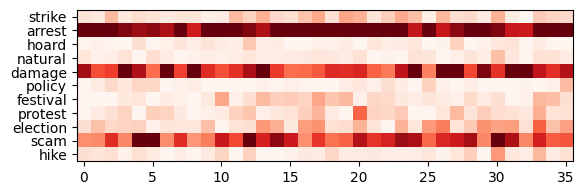

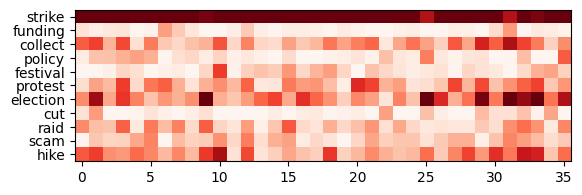

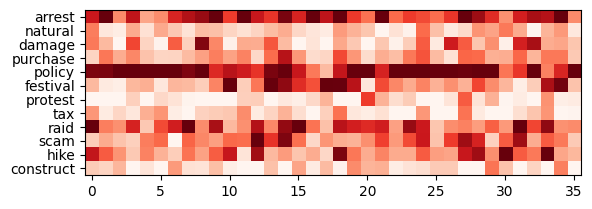

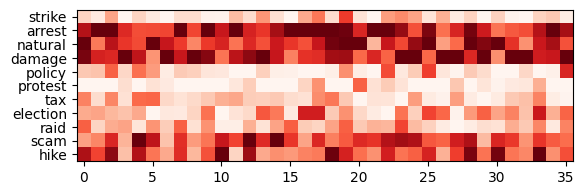

In [161]:
crops = ['Onion','Potato','Wheat','Rice']
path='/content/gdrive/MyDrive/Colab Notebooks/REN/'
mnth_days = [31,28,31,30,31,30,31,31,30,31,30,31]*3
num_top = 5
shap = True
event_codes = cp.load(open(path+'event importance/event_codes.dict','rb'))

for crop in crops:
  event_dict = {}
  #if True:
  model = keras.models.load_model(path+'onedayahead_logreturn/ren_'+crop)
  fileformat = path+'food_price_data/%s.csv'
  data = pd.read_csv(fileformat%(crop))
  price = data['price']
  dates = data['date']
  #foodpriceDf = pd.Series(food_price,index=dates)
  start_date = '2012-12-25'
  end_date = '2015-12-31'
  price.index = dates
  price = np.log(price).diff()[1:]
  range_price = price[2548:2548+1102]#[start_date:end_date]
  #food_price = np.log(range_price).diff()[1:]
  price_diff = np.array(range_price).reshape(range_price.shape[0],1)
  train = np.load(path+'embeddings/events_train.npy')
  test = np.load(path+'embeddings/events_test.npy')
  events = np.append(train,test, axis=0)[2549:2549+1102]
  mean_events = events.mean(axis=0)
  #mean_events = np.zeros(250)
  X, y   = addSpanLag(price_diff,events,look_back=7,look_ahead=0,season=0)
  gradients = getScore(model,X)
  gradients = gradients[:,:,1:]
  events_lagged = np.abs(X[:,:,1:] - mean_events[np.newaxis, np.newaxis, :])
  #print(X.shape,events_lagged.shape)
  #c=np.multiply(a[2557:,b)

  st = 0
  top_events = []
  for i in range(36):
    end = st+mnth_days[i]
    #print(st,end)
    c = np.multiply(gradients[st:end],events_lagged[st:end]) if shap else gradients[st:end]
    #c = c[:, [-1], :]
    # print(c.shape)
    c = (c.sum(axis=1).sum(axis=0)/mnth_days[i]).reshape(c.shape[2],1)
    top = np.argmax(c)
    topval = np.max(c,axis=1)
    #print(c.flatten())
    top_argsort = np.argsort(-c.flatten())[:num_top]
    # print(i, top, c.flatten()[top], c[:10])
    #print(top10_argsort, c.flatten()[top10_argsort])
    #for i in range(end-st):
    #ind = np.argpartition(c, -10,axis=0)[-10:]
    #top10 = np.flip(ind).flatten()
    #top10 = np.array(top10)
    top_events += list(top_argsort)
    st = end

  top_events = list(set(top_events))
  print(f'Top events for {crop} = {top_events}')
  # top_events = [1, 232, 149]
  event_vals_months = []
  st = 0
  for i in range(36):
    end = st+mnth_days[i]
    #print(st,end)
    c = np.multiply(gradients[st:end],events_lagged[st:end]) if shap else gradients[st:end]
    #c = c[:, [-1], :]
    c = (c.sum(axis=1).sum(axis=0)/mnth_days[i]).reshape(c.shape[2],1)
    top = np.argmax(c)
    # print(i, top, c.flatten()[top], c[:10])
    event_vals = []
    for k in top_events:
      #print(f'month {i}event{k} score {c[k]}')
      event_vals.append(c[k][0])
    mx = max(event_vals)
    mn = min(event_vals)
    # print(mx,mn)
    event_vals=[(val-mn)/(mx-mn) for val in event_vals]
    # print(event_vals)
    event_vals_months.append(event_vals)
    st = end

  event_vals_months = np.array(event_vals_months).T
  #print(f'event vals months = {event_vals_months}')
  # event_vals_months = event_vals_months.reshape(event_vals_months.shape[0],event_vals_months.shape[1]).T
  #print(event_vals_months.shape)
  fig, ax = plt.subplots()
  im = ax.imshow(event_vals_months,cmap=plt.colormaps["Reds"])
  top_event_names = [event_codes[ev] for ev in top_events]
  ax.set_yticks(np.arange(len(top_events)), labels=top_event_names)